In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# Enable FP16

# https://medium.com/@noel_kennedy/how-to-use-half-precision-float16-when-training-on-rtx-cards-with-tensorflow-keras-d4033d59f9e4

import tensorflow.keras.backend as K

K.set_floatx('float16')

# default is 1e-7 which is too small for float16.  
# Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4)

In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = './data/train/'
VAL_FOLDER_PATH = './data/validation/'
TEST_FOLDER_PATH = './data/test/'

In [4]:
# Hyper parameters

learning_rate = 0.001
batch_size = 20
num_epochs = 60
classes = 2
loss = "binary_crossentropy"

In [5]:
# Data generator

data_gen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

def get_train_generator(img_height, img_width):
    train_generator = data_gen.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return train_generator

def get_validation_generator(img_height, img_width):
    validation_generator = data_gen.flow_from_directory(
        VAL_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return validation_generator

def get_test_generator(img_height, img_width):
    test_generator = data_gen.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return test_generator

In [6]:
# Callbacks
def get_callbacks():
    mc = ModelCheckpoint('best_fp16.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
    
    return [mc]


In [7]:
# Compile the model

def compile_model(model):
    opt = SGD(lr = learning_rate)
    
    model.compile(loss = loss, optimizer = opt, metrics=["accuracy", MCC])
    
    return model

In [8]:
# Fit the model

def fit_model(model, train_generator, validation_generator):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        epochs = num_epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size,
        use_multiprocessing = False,
        callbacks = get_callbacks())
    
    return history, model


In [9]:
# Save model
def save_model(model, model_name):
    model.save(model_name + '.h5')

In [10]:
# Evaluate the model

def evaluate_model(model, validation_generator):
    return model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)


In [11]:
# Predictions

def get_predictions(model, test_generator):
    test_generator.reset()
    
    predIdx = model.predict_generator(test_generator, steps = (test_generator.n // test_generator.batch_size) + 1)
    
    predIdx = np.argmax(predIdx, axis=1)
    
    return predIdx

In [12]:
# Plot accuracy and loss

def plot_metrics(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    # summarize history for loss
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    
    # Plot MCC values
    plt.subplot(2,2,3)
    plt.plot(history.history['MCC'])
    plt.plot(history.history['val_MCC'])
    plt.title('model MCC')
    plt.ylabel('MCC')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [13]:
# Show evaluation metrics

def show_eval_metrics(model, metrics):
    for idx, m in enumerate(model.metrics_names):
        print("{}: {:.4f}".format(m, metrics[idx]))


In [27]:
# Show test metrics

def show_test_metrics(predictions, test_generator):
    print("## Classification report ##")
    print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(test_generator.classes, predictions)
    print("## Confusion matrix ##")
    print(cm)
    
    total = sum(sum(cm))
    acc = (cm[0,0] + cm[1,1]) / total
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    specificity = cm[1,1] / (cm[1,0] + cm[1,1])

    print("## Other values ##")
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    

In [15]:
# Xception model

from tensorflow.keras.applications.xception import Xception

img_width = 299
img_height = 299
img_depth = 3

xception_model = Xception(weights='imagenet', include_top=False, input_shape = (img_height, img_width, img_depth))

model = Sequential()
model.add(xception_model)

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Dense(2))
model.add(Activation("softmax"))

xception_model.trainable = False

# Hyperparameters

learning_rate = 2e-5
num_epochs = 40


83689472/83683744 [==============================] - 20s 0us/step


In [16]:
# Compile

model = compile_model(model)

In [17]:
# Create the generators

train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 227 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [18]:
# Train

history, model = fit_model(model, train_generator, validation_generator)

Epoch 1/40


W0731 10:37:13.077357 140206211323712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/11 [==========================>...] - ETA: 3s - loss: 1.0099 - accuracy: 0.5723 - MCC: 0.0143
Epoch 00001: val_MCC improved from -inf to 0.00000, saving model to best_fp16.h5
11/11 [==============================] - 47s 4s/step - loss: 1.0581 - accuracy: 0.5557 - MCC: 0.0130 - val_loss: 0.7332 - val_accuracy: 0.5669 - val_MCC: 0.0000e+00
Epoch 2/40
10/11 [==========================>...] - ETA: 3s - loss: 0.9517 - accuracy: 0.6099 - MCC: 0.0000e+00
Epoch 00002: val_MCC did not improve from 0.00000
11/11 [==============================] - 46s 4s/step - loss: 0.9592 - accuracy: 0.6089 - MCC: 0.0000e+00 - val_loss: 0.6727 - val_accuracy: 0.6167 - val_MCC: 0.0000e+00
Epoch 3/40
10/11 [==========================>...] - ETA: 2s - loss: 0.8301 - accuracy: 0.6323 - MCC: 0.0286 
Epoch 00003: val_MCC did not improve from 0.00000
11/11 [==============================] - 41s 4s/step - loss: 0.8208 - accuracy: 0.6338 - MCC: 0.0260 - val_loss: 0.6408 - val_accuracy: 0.6499 - val_MCC: 0.0000e+00
Ep

10/11 [==========================>...] - ETA: 2s - loss: 0.3499 - accuracy: 0.8608 - MCC: 0.1000
Epoch 00026: val_MCC did not improve from 0.00000
11/11 [==============================] - 43s 4s/step - loss: 0.3423 - accuracy: 0.8647 - MCC: 0.0909 - val_loss: 0.1362 - val_accuracy: 0.9668 - val_MCC: 0.0000e+00
Epoch 27/40
10/11 [==========================>...] - ETA: 2s - loss: 0.3844 - accuracy: 0.8394 - MCC: 0.0428  
Epoch 00027: val_MCC did not improve from 0.00000
11/11 [==============================] - 41s 4s/step - loss: 0.3556 - accuracy: 0.8501 - MCC: 0.0389 - val_loss: 0.2374 - val_accuracy: 0.8667 - val_MCC: 0.0000e+00
Epoch 28/40
10/11 [==========================>...] - ETA: 2s - loss: 0.2654 - accuracy: 0.8931 - MCC: 0.1000  
Epoch 00028: val_MCC did not improve from 0.00000
11/11 [==============================] - 36s 3s/step - loss: 0.2648 - accuracy: 0.8936 - MCC: 0.0909 - val_loss: 0.2196 - val_accuracy: 0.9165 - val_MCC: 0.0000e+00
Epoch 29/40
10/11 [=================

In [19]:
# Save model
save_model(model, 'fp16')

In [20]:
# Evaluate

metrics = evaluate_model(model, validation_generator)
show_eval_metrics(model, metrics)

loss: 0.1228
accuracy: 0.9668
MCC: 0.0000


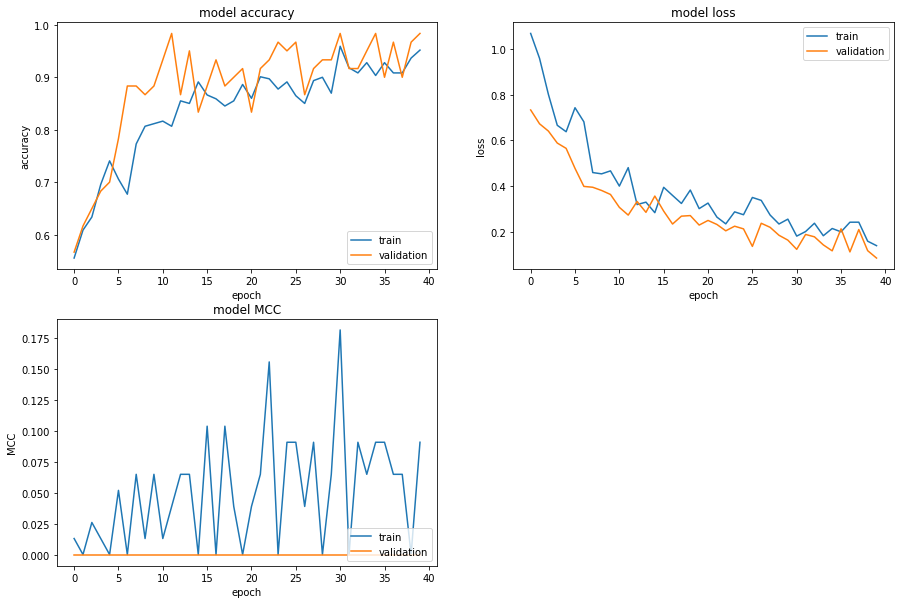

In [21]:
# Plot metrics from history

plot_metrics(history)

In [22]:
# Predictions

predictions = get_predictions(model, test_generator)

In [28]:
# Show final metrics

show_test_metrics(predictions, test_generator)

## Classification report ##
              precision    recall  f1-score   support

      Blacky       0.95      1.00      0.98        20
       Niche       1.00      0.96      0.98        27

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47

## Confusion matrix ##
[[20  0]
 [ 1 26]]
## Other values ##
acc: 0.9787
sensitivity: 1.0000
specificity: 0.9630
